In [26]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn tensorflow

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
np.random.seed(42)

## Load Prophet Predictions and Compute Residuals

For each timeframe, load the CSV predictions and calculate:
$$\text{residual} = \text{actual} - \text{prophet_prediction}$$

1. Apply seasonal decomposition to residuals (trend + seasonal + resid)
2. Train LSTM on (trend + resid) components only
3. Add back seasonal component for final predictions

In [28]:
def load_prophet_predictions_all_splits(tf):
    df = pd.read_csv(f'prophet_{tf}_all_predictions.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df.sort_values('timestamp').reset_index(drop=True)


def compute_residuals_with_decomposition(tf):

    prophet_preds = load_prophet_predictions_all_splits(tf)


    train_preds = prophet_preds[prophet_preds['split'] == 'train'].copy()
    valid_preds = prophet_preds[prophet_preds['split'] == 'valid'].copy()
    test_preds = prophet_preds[prophet_preds['split'] == 'test'].copy()


    train_preds['residual'] = train_preds['actual'] - train_preds['predicted']
    valid_preds['residual'] = valid_preds['actual'] - valid_preds['predicted']
    test_preds['residual'] = test_preds['actual'] - test_preds['predicted']

    # Apply seasonal decomposition to residuals
    # This separates: residual = trend + seasonal + resid
    print(f"Applying seasonal decomposition to {tf} residuals...")

    # Determine period based on timeframe
    if tf == '1m':
        period = 24 * 60
    elif tf == '5m':
        period = 24 * 12
    elif tf == '15m':
        period = 24 * 4
    else:
        period = 24

    print(f"Using period={period} ({period} timesteps = 24 hours for {tf} data)")

    # Train decomposition
    train_series = pd.Series(train_preds['residual'].values,
                             index=pd.to_datetime(train_preds['timestamp']))
    train_decomp = sm.tsa.seasonal_decompose(train_series,
                                             model='additive',
                                             period=period,
                                             extrapolate_trend='freq')

    # Valid decomposition
    valid_series = pd.Series(valid_preds['residual'].values,
                             index=pd.to_datetime(valid_preds['timestamp']))
    valid_decomp = sm.tsa.seasonal_decompose(valid_series,
                                             model='additive',
                                             period=period,
                                             extrapolate_trend='freq')

    # Test decomposition
    test_series = pd.Series(test_preds['residual'].values,
                            index=pd.to_datetime(test_preds['timestamp']))
    test_decomp = sm.tsa.seasonal_decompose(test_series,
                                            model='additive',
                                            period=period,
                                            extrapolate_trend='freq')

    # Create LSTM target: trend + resid (exclude seasonal)
    train_preds['trend'] = train_decomp.trend.values
    train_preds['seasonal'] = train_decomp.seasonal.values
    train_preds['resid'] = train_decomp.resid.values
    train_preds['lstm_target'] = train_decomp.trend.values + train_decomp.resid.values

    valid_preds['trend'] = valid_decomp.trend.values
    valid_preds['seasonal'] = valid_decomp.seasonal.values
    valid_preds['resid'] = valid_decomp.resid.values
    valid_preds['lstm_target'] = valid_decomp.trend.values + valid_decomp.resid.values

    test_preds['trend'] = test_decomp.trend.values
    test_preds['seasonal'] = test_decomp.seasonal.values
    test_preds['resid'] = test_decomp.resid.values
    test_preds['lstm_target'] = test_decomp.trend.values + test_decomp.resid.values

    # Handle NaN values from decomposition (first/last few points) using modern pandas syntax
    train_preds['lstm_target'] = train_preds['lstm_target'].bfill().ffill()
    valid_preds['lstm_target'] = valid_preds['lstm_target'].bfill().ffill()
    test_preds['lstm_target'] = test_preds['lstm_target'].bfill().ffill()

    return {
        'train': train_preds.reset_index(drop=True),
        'valid': valid_preds.reset_index(drop=True),
        'test': test_preds.reset_index(drop=True)
    }


# Process all timeframes
timeframes = ['1m', '5m', '15m']
residuals_all = {}

print(f"\n{'='*80}")
print(f"Loading Prophet predictions and computing residuals with decomposition")
print(f"{'='*80}")
print(f"\nFollowing Hybrid Model approach:")
print(f"1. Compute residuals = actual - prophet_prediction")
print(f"2. Apply seasonal decomposition: residual = trend + seasonal + resid")
print(f"3. LSTM learns (trend + resid) component only")
print(f"4. Add back seasonal component for final predictions")
print(f"\n{'='*80}\n")

for tf in timeframes:
    print(f"\n{'='*60}")
    print(f"Processing residuals for {tf.upper()}")
    print(f"{'='*60}")

    try:
        residuals_all[tf] = compute_residuals_with_decomposition(tf)

        print(f"✅ Loaded and decomposed successfully!")
        print(f"Train: {len(residuals_all[tf]['train'])} samples")
        print(f"Valid: {len(residuals_all[tf]['valid'])} samples")
        print(f"Test:  {len(residuals_all[tf]['test'])} samples")

        print(f"\nOriginal residuals stats:")
        print(residuals_all[tf]['train']['residual'].describe())

        print(f"\nLSTM target (trend+resid) stats:")
        print(residuals_all[tf]['train']['lstm_target'].describe())

    except FileNotFoundError as e:
        print(f"❌ Error: File not found!")
        print(f"   Please run train_prophet.ipynb first to generate predictions.")
        print(f"   Make sure to run the cell that exports 'prophet_{tf}_all_predictions.csv'")
        raise


Loading Prophet predictions and computing residuals with decomposition

Following Hybrid Model approach:
1. Compute residuals = actual - prophet_prediction
2. Apply seasonal decomposition: residual = trend + seasonal + resid
3. LSTM learns (trend + resid) component only
4. Add back seasonal component for final predictions



Processing residuals for 1M
Applying seasonal decomposition to 1m residuals...
Using period=1440 (1440 timesteps = 24 hours for 1m data)
✅ Loaded and decomposed successfully!
Train: 60528 samples
Valid: 15132 samples
Test:  13620 samples

Original residuals stats:
count    60528.000000
mean        -0.000155
std         14.065172
min       -164.671281
25%         -7.524119
50%         -0.494809
75%          6.472708
max        180.718262
Name: residual, dtype: float64

LSTM target (trend+resid) stats:
count    60528.000000
mean        -0.000316
std         13.894861
min       -161.003202
25%         -7.415967
50%         -0.512828
75%          6.449770
max        1

## Visualize Residual Time Series


Visualizing decomposed residuals for 1M...


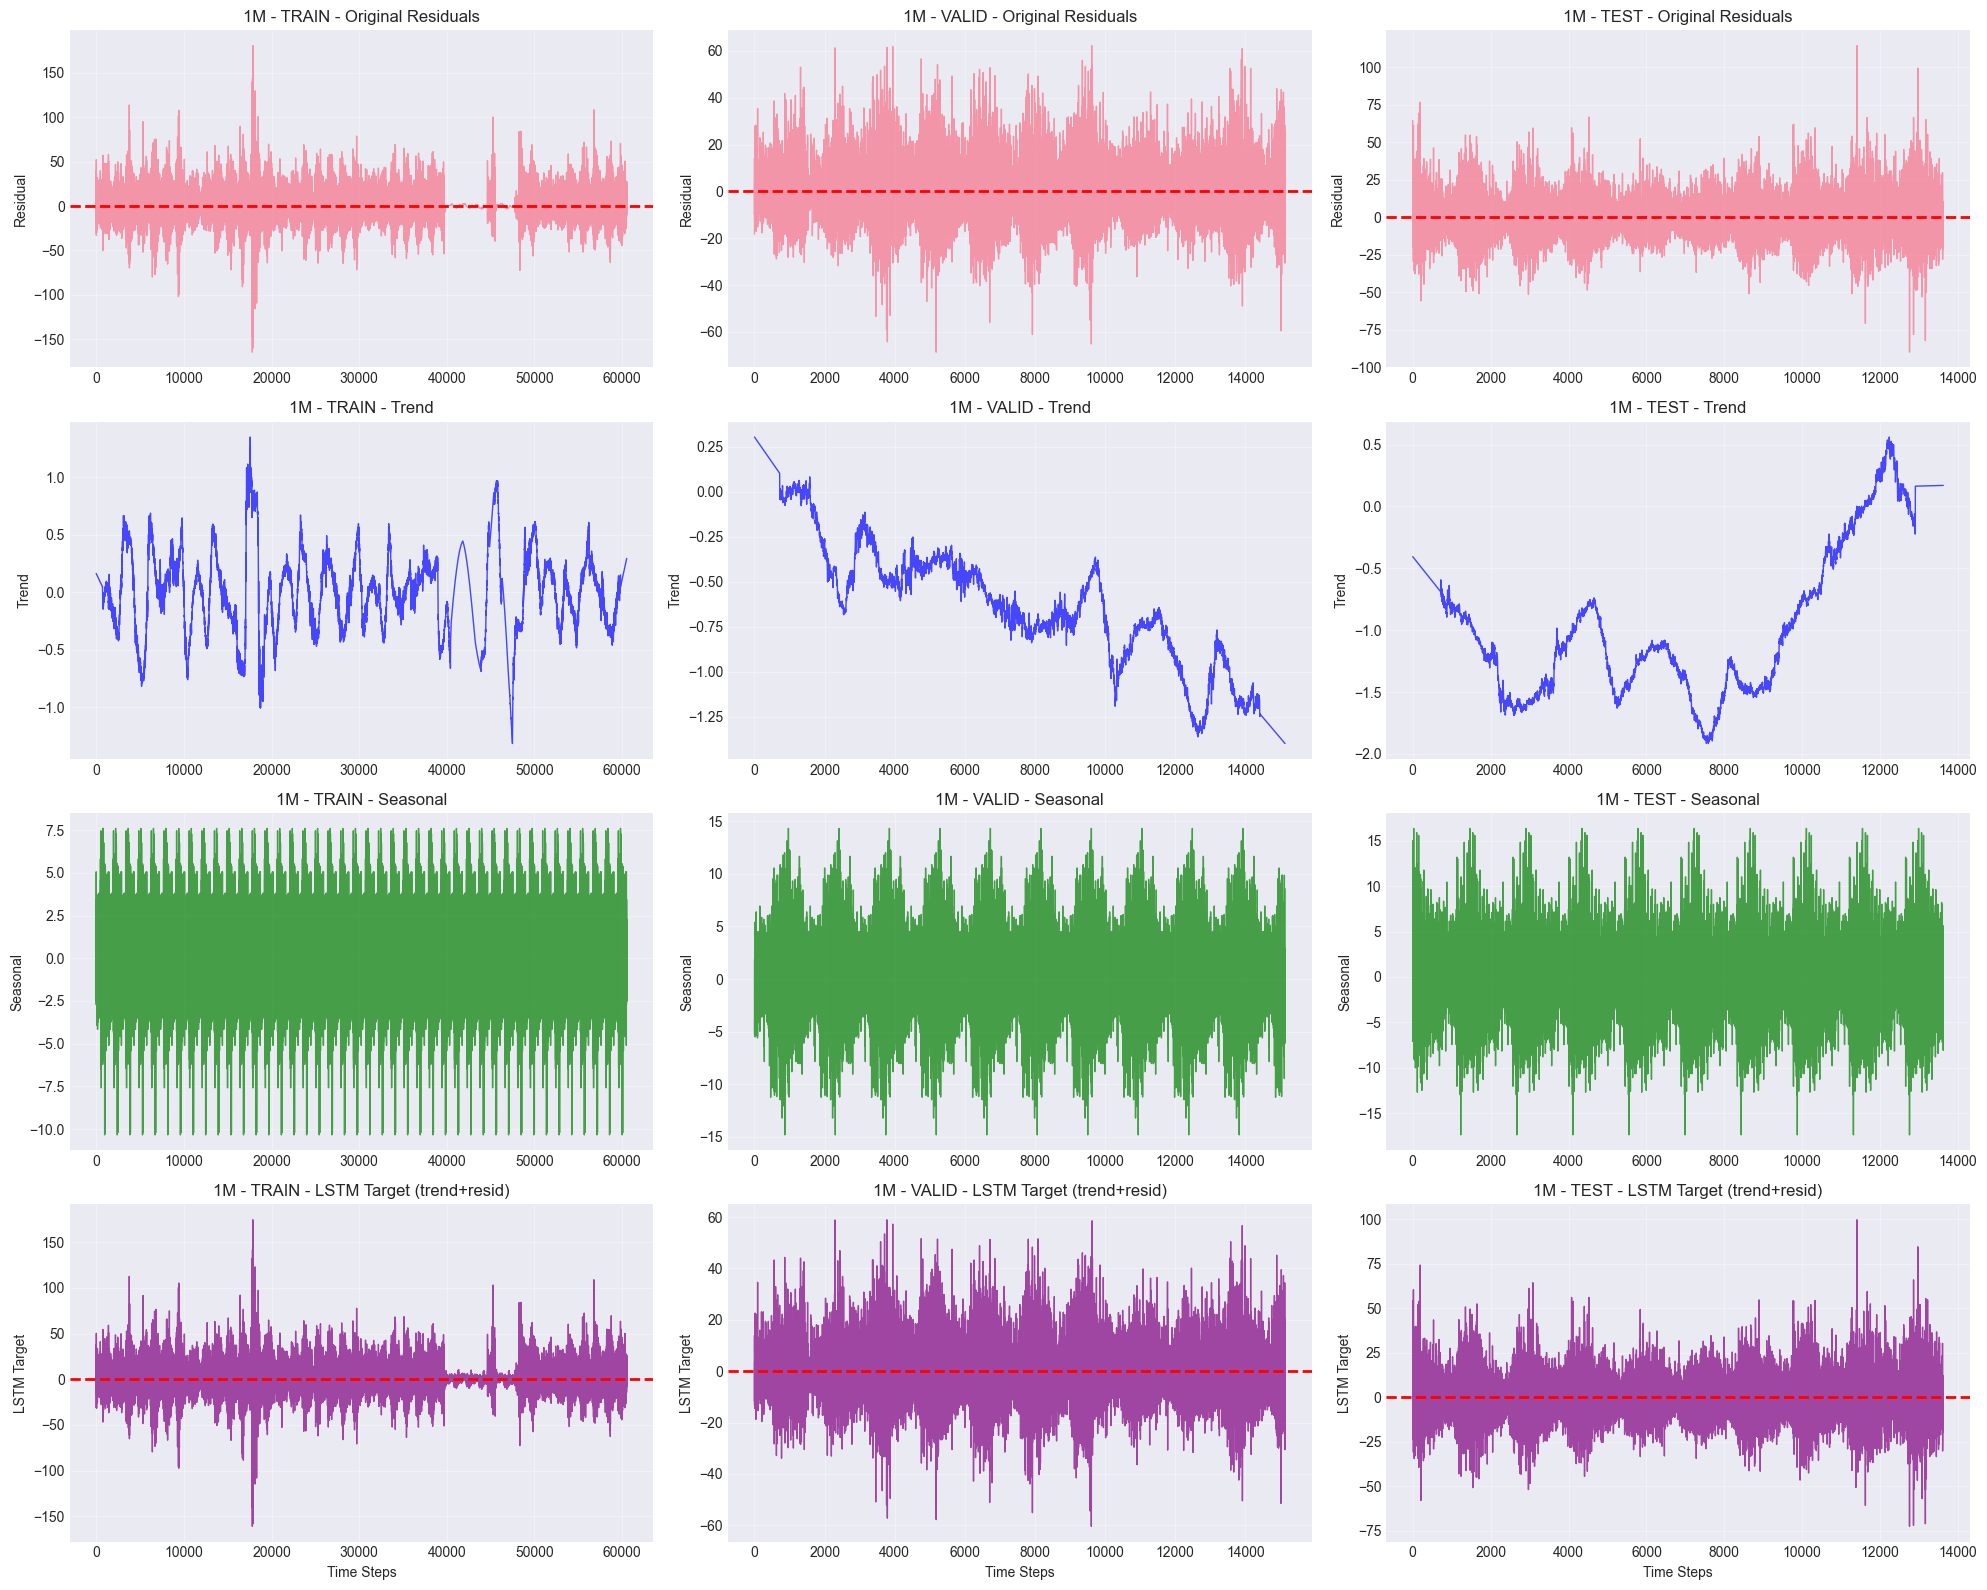

Decomposed residuals plot saved: residuals_1m_decomposed.png

Visualizing decomposed residuals for 5M...


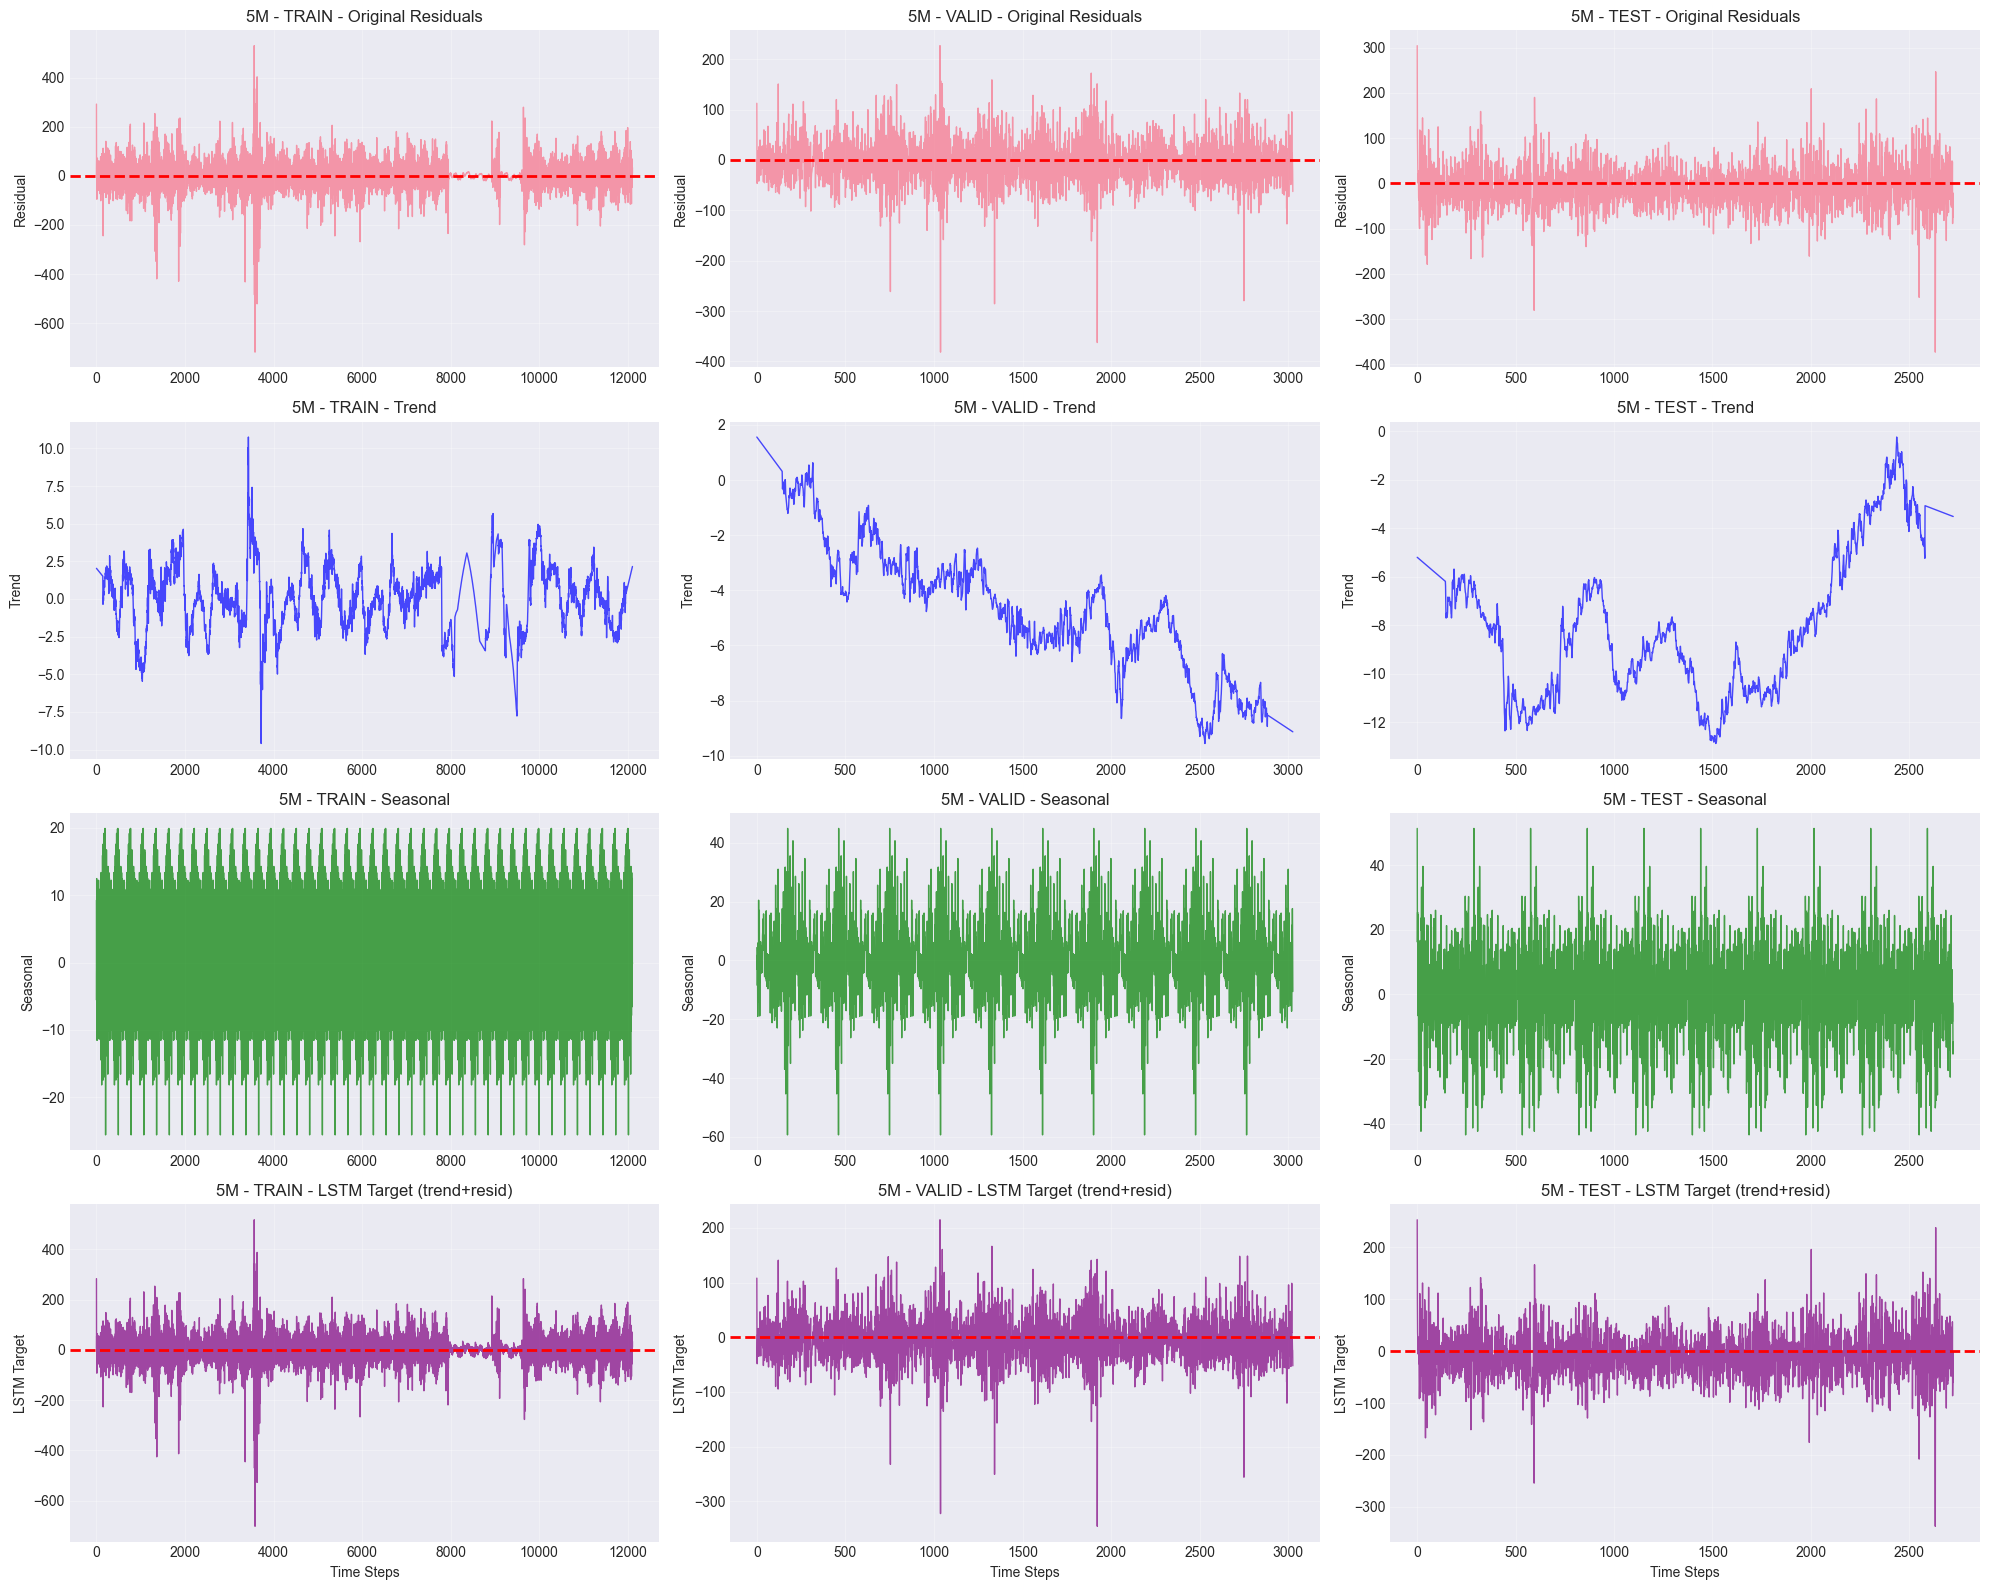

Decomposed residuals plot saved: residuals_5m_decomposed.png

Visualizing decomposed residuals for 15M...


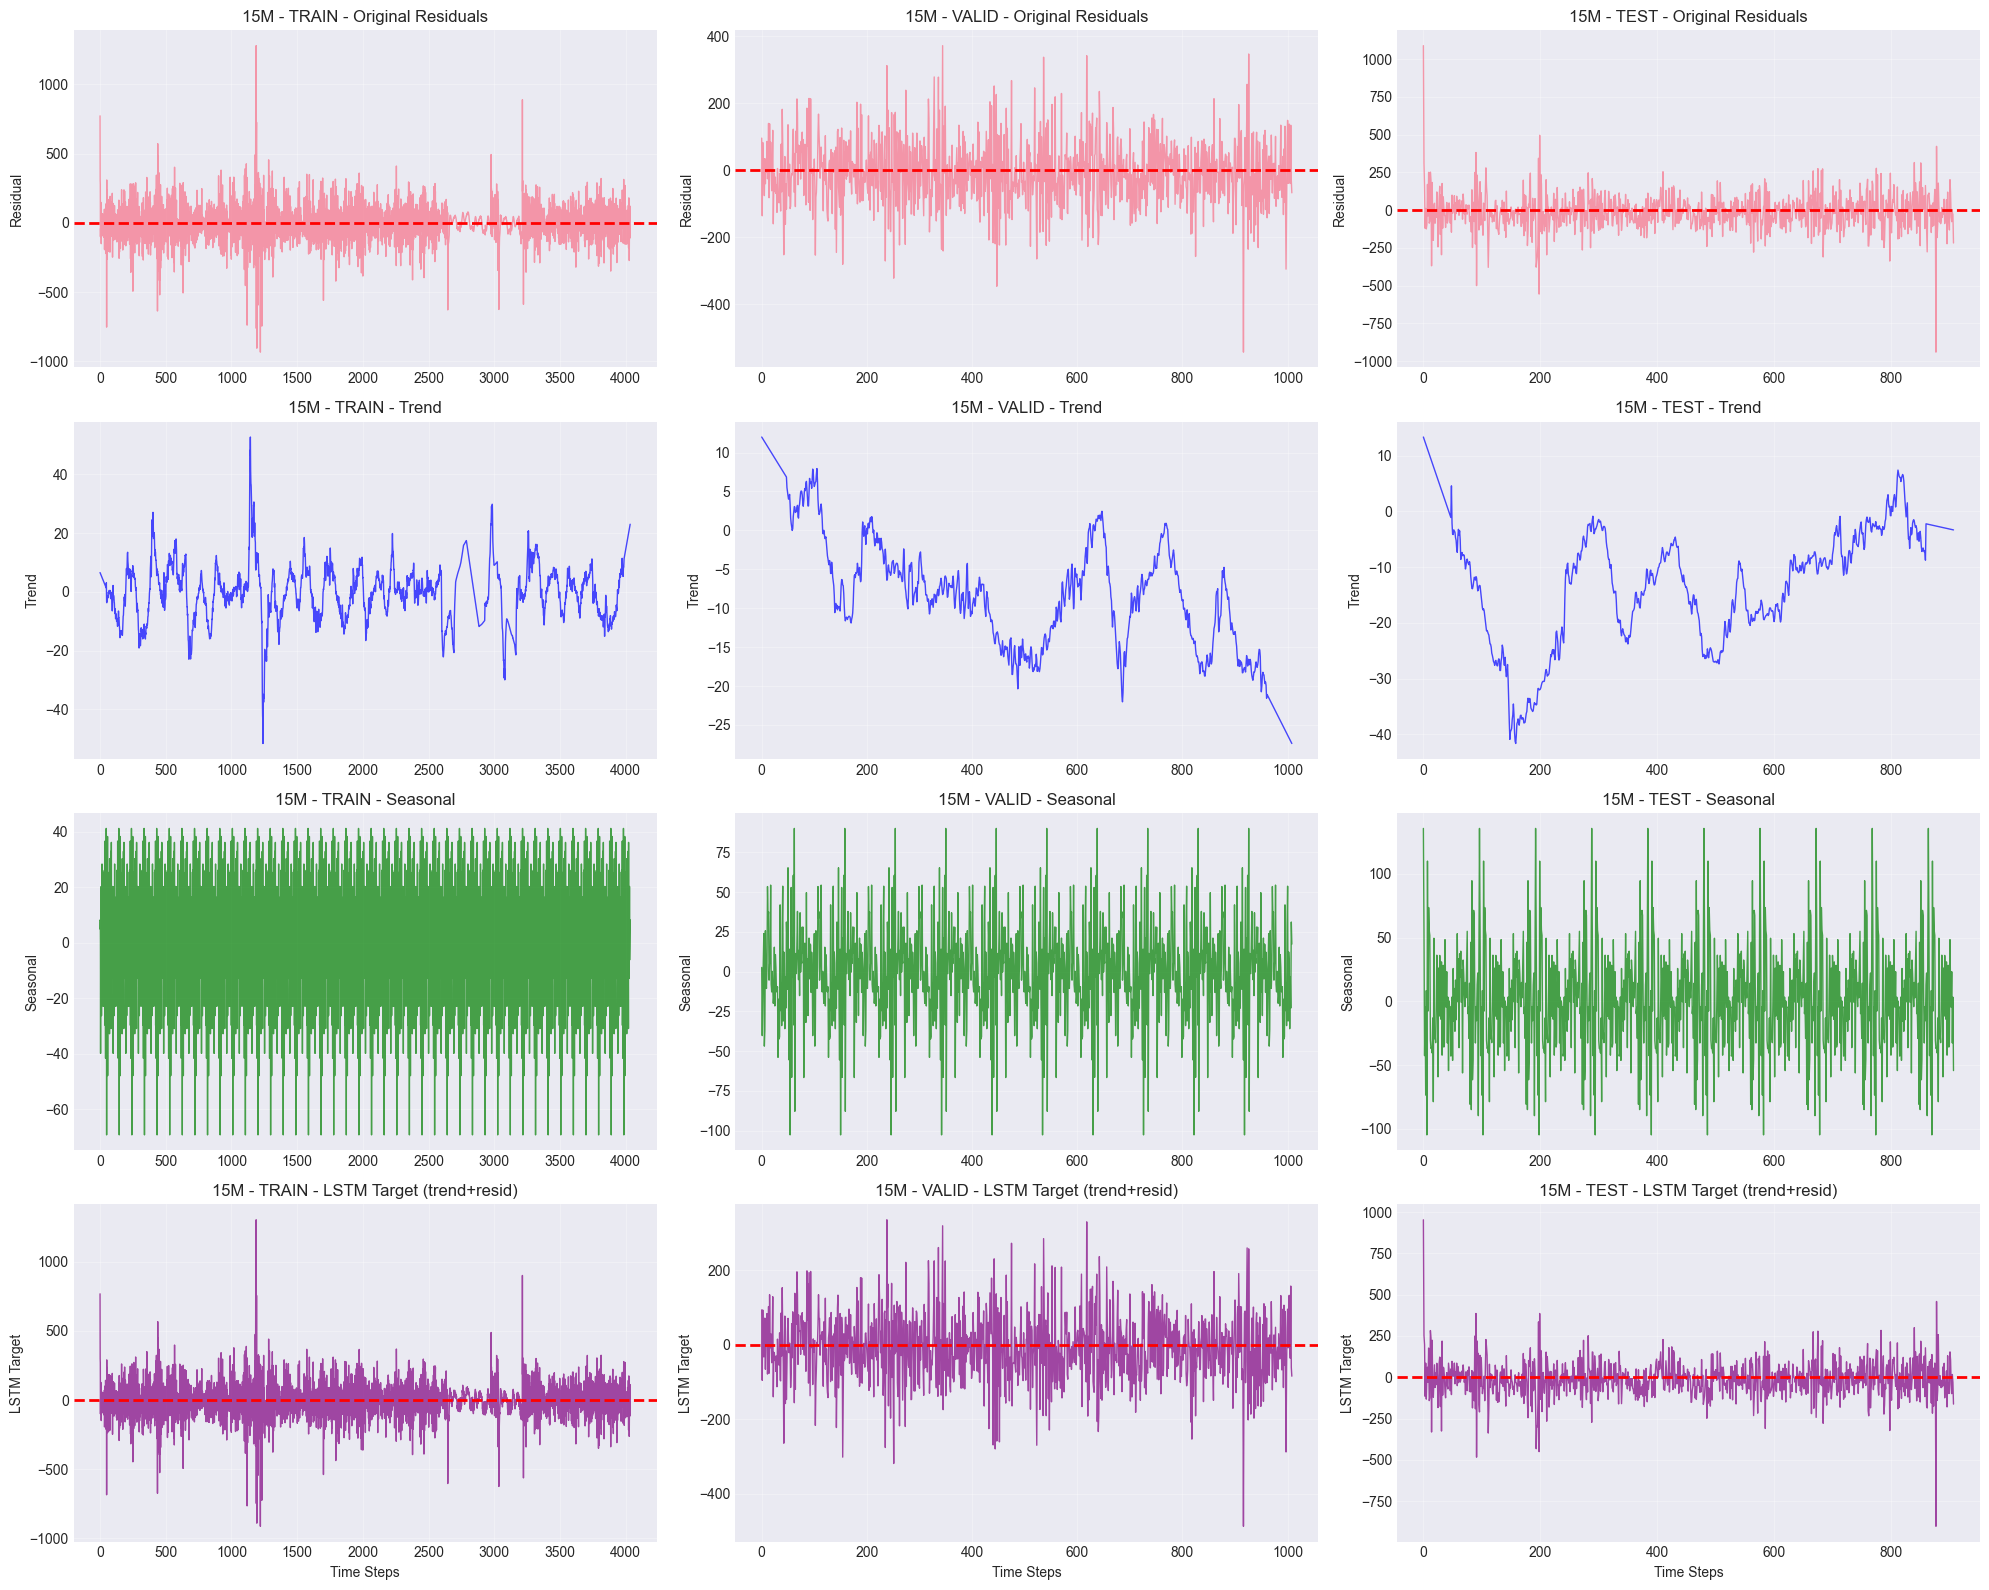

Decomposed residuals plot saved: residuals_15m_decomposed.png


In [29]:
# Visualize decomposed residuals for each timeframe
for tf in timeframes:
    print(f"\nVisualizing decomposed residuals for {tf.upper()}...")

    fig, axes = plt.subplots(4, 3, figsize=(20, 16))

    for col_idx, split in enumerate(['train', 'valid', 'test']):
        data = residuals_all[tf][split]

        # Original residuals
        ax = axes[0, col_idx]
        ax.plot(data.index, data['residual'], linewidth=1, alpha=0.7)
        ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
        ax.set_title(f'{tf.upper()} - {split.upper()} - Original Residuals')
        ax.set_ylabel('Residual')
        ax.grid(True, alpha=0.3)

        # Trend component
        ax = axes[1, col_idx]
        ax.plot(data.index, data['trend'], linewidth=1, color='blue', alpha=0.7)
        ax.set_title(f'{tf.upper()} - {split.upper()} - Trend')
        ax.set_ylabel('Trend')
        ax.grid(True, alpha=0.3)

        # Seasonal component
        ax = axes[2, col_idx]
        ax.plot(data.index, data['seasonal'], linewidth=1, color='green', alpha=0.7)
        ax.set_title(f'{tf.upper()} - {split.upper()} - Seasonal')
        ax.set_ylabel('Seasonal')
        ax.grid(True, alpha=0.3)

        # LSTM target (trend + resid)
        ax = axes[3, col_idx]
        ax.plot(data.index, data['lstm_target'], linewidth=1, color='purple', alpha=0.7)
        ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
        ax.set_title(f'{tf.upper()} - {split.upper()} - LSTM Target (trend+resid)')
        ax.set_ylabel('LSTM Target')
        ax.set_xlabel('Time Steps')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'residuals_{tf}_decomposed.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Decomposed residuals plot saved: residuals_{tf}_decomposed.png")

## Prepare LSTM Datasets


**Model Approach**:
1. **Seasonal Decomposition**: residual = trend + seasonal + resid
2. **LSTM Target**: Learn (trend + resid) only
3. **Scaling**: MinMaxScaler fit on training data
4. **Architecture**: Bidirectional LSTM with Dropout
5. **Prediction**: Autoregressive for test set
6. **Final Output**: Add seasonal component back

**Window Size Choices**:
- **1m data, window=24**: Last 24 minutes (hourly pattern)
- **5m data, window=24**: Last 120 minutes (2 hours)
- **15m data, window=24**: Last 360 minutes (6 hours)

## Build and Train Bidirectional LSTM Model


In [30]:
def prepare_lstm_dataset_hybrid(residuals_train, residuals_valid, residuals_test, window_size=24):

    # Reshape for scaler: (n_samples, 1)
    train_data = residuals_train.reshape(-1, 1)
    valid_data = residuals_valid.reshape(-1, 1)
    test_data = residuals_test.reshape(-1, 1)

    # Initialize and fit scaler on training data
    scaler = MinMaxScaler()
    scaler.fit(train_data)

    # Scale all datasets
    scaled_train = scaler.transform(train_data).flatten()
    scaled_valid = scaler.transform(valid_data).flatten()
    scaled_test = scaler.transform(test_data).flatten()

    # Create sliding windows
    def create_sequences(data, n_steps):
        X, y = [], []
        for i in range(len(data) - n_steps):
            X.append(data[i:i + n_steps])
            y.append(data[i + n_steps])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(scaled_train, window_size)
    X_valid, y_valid = create_sequences(scaled_valid, window_size)
    X_test, y_test = create_sequences(scaled_test, window_size)

    # Reshape X for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    return {
        'X_train': X_train,
        'y_train': y_train,
        'X_valid': X_valid,
        'y_valid': y_valid,
        'X_test': X_test,
        'y_test': y_test,
        'scaler': scaler,
        'train_original': residuals_train,
        'valid_original': residuals_valid,
        'test_original': residuals_test
    }


# Prepare datasets for all timeframes with window_size=24
window_size = 24
lstm_datasets = {}

for tf in timeframes:
    print(f"\n{'='*60}")
    print(f"Preparing LSTM dataset for {tf.upper()} (window_size={window_size})")
    print(f"{'='*60}")

    # Use lstm_target (trend + resid) for LSTM training
    lstm_datasets[tf] = prepare_lstm_dataset_hybrid(
        residuals_all[tf]['train']['lstm_target'].values,
        residuals_all[tf]['valid']['lstm_target'].values,
        residuals_all[tf]['test']['lstm_target'].values,
        window_size=window_size
    )

    print(f"Scaled Data (MinMaxScaler):")
    print(f"  X_train: shape={lstm_datasets[tf]['X_train'].shape}, " +
          f"min={lstm_datasets[tf]['X_train'].min():.4f}, max={lstm_datasets[tf]['X_train'].max():.4f}")
    print(f"  y_train: shape={lstm_datasets[tf]['y_train'].shape}, " +
          f"min={lstm_datasets[tf]['y_train'].min():.4f}, max={lstm_datasets[tf]['y_train'].max():.4f}")
    print(f"  X_valid: shape={lstm_datasets[tf]['X_valid'].shape}")
    print(f"  X_test:  shape={lstm_datasets[tf]['X_test'].shape}")

    # Store seasonal components for later use
    lstm_datasets[tf]['train_seasonal'] = residuals_all[tf]['train']['seasonal'].values
    lstm_datasets[tf]['valid_seasonal'] = residuals_all[tf]['valid']['seasonal'].values
    lstm_datasets[tf]['test_seasonal'] = residuals_all[tf]['test']['seasonal'].values


Preparing LSTM dataset for 1M (window_size=24)
Scaled Data (MinMaxScaler):
  X_train: shape=(60504, 24, 1), min=0.0000, max=1.0000
  y_train: shape=(60504,), min=0.0000, max=1.0000
  X_valid: shape=(15108, 24, 1)
  X_test:  shape=(13596, 24, 1)

Preparing LSTM dataset for 5M (window_size=24)
Scaled Data (MinMaxScaler):
  X_train: shape=(12081, 24, 1), min=0.0000, max=1.0000
  y_train: shape=(12081,), min=0.0000, max=1.0000
  X_valid: shape=(3003, 24, 1)
  X_test:  shape=(2700, 24, 1)

Preparing LSTM dataset for 15M (window_size=24)
Scaled Data (MinMaxScaler):
  X_train: shape=(4011, 24, 1), min=0.0000, max=1.0000
  y_train: shape=(4011,), min=0.0000, max=1.0000
  X_valid: shape=(985, 24, 1)
  X_test:  shape=(884, 24, 1)


## Build and Train LSTM Model



In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def build_lstm_model_hybrid(window_size, lstm_units=32):
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(window_size, 1)),

        # First Bidirectional LSTM layer
        layers.Bidirectional(
            layers.LSTM(lstm_units, return_sequences=True, activation='relu')
        ),
        layers.Dropout(0.2),

        # Second Bidirectional LSTM layer
        layers.Bidirectional(
            layers.LSTM(lstm_units, return_sequences=True, activation='relu')
        ),
        layers.Dropout(0.2),

        # Third Bidirectional LSTM layer (no return_sequences)
        layers.Bidirectional(
            layers.LSTM(lstm_units, activation='relu')
        ),
        layers.Dropout(0.2),

        # Dense output layer
        layers.Dense(1)
    ])

    # Compile with MSE loss and Adam optimizer
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return model


# Build models for each timeframe
lstm_models = {}

for tf in timeframes:
    print(f"\n{'='*60}")
    print(f"Building Bidirectional LSTM model for {tf.upper()}")
    print(f"{'='*60}")

    lstm_models[tf] = build_lstm_model_hybrid(window_size=window_size, lstm_units=32)
    lstm_models[tf].summary()

    print(f"✅ Model built for {tf.upper()}")


Building Bidirectional LSTM model for 1M


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_18                │ (None, 24, 64)         │         8,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 24, 64)         │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,433 (228.25 KB)

 Trainable params: 58,433 (228.25 KB)

 Non-trainable params: 0 (0.00 B)

✅ Model built for 1M

Building Bidirectional LSTM model for 5M


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_21                │ (None, 24, 64)         │         8,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 24, 64)         │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,433 (228.25 KB)

 Trainable params: 58,433 (228.25 KB)

 Non-trainable params: 0 (0.00 B)

✅ Model built for 5M

Building Bidirectional LSTM model for 15M


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_24                │ (None, 24, 64)         │         8,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 24, 64)         │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,433 (228.25 KB)

 Trainable params: 58,433 (228.25 KB)

 Non-trainable params: 0 (0.00 B)

✅ Model built for 15M


In [32]:
import os

# Create directory for saved models
model_dir = 'lstm_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Created directory: {model_dir}")

# Training parameters
epochs = 100
batch_size = 32
patience = 15

# Train models for each timeframe
training_history = {}

for tf in timeframes:
    print(f"\n{'='*80}")
    print(f"Training Bidirectional LSTM model for {tf.upper()}")
    print(f"{'='*80}")

    # Data is already in correct shape from prepare_lstm_dataset_hybrid
    X_train = lstm_datasets[tf]['X_train']
    y_train = lstm_datasets[tf]['y_train']
    X_valid = lstm_datasets[tf]['X_valid']
    y_valid = lstm_datasets[tf]['y_valid']

    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_valid.shape}")

    # Callbacks
    model_path = f"{model_dir}/lstm_{tf}_best.keras"
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            model_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]


    history = lstm_models[tf].fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    training_history[tf] = history.history

    print(f"\n✅ Model trained and saved: {model_path}")
    print(f"Best validation loss: {min(history.history['val_loss']):.6f}")
    print(f"Best validation MAE: {min(history.history['val_mae']):.6f}")


Training Bidirectional LSTM model for 1M
Training data shape: (60504, 24, 1)
Validation data shape: (15108, 24, 1)
Epoch 1/100
1890/1891 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0098 - mae: 0.0610
Epoch 1: val_loss improved from None to 0.00141, saving model to lstm_models/lstm_1m_best.keras

Epoch 1: finished saving model to lstm_models/lstm_1m_best.keras
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - loss: 0.0041 - mae: 0.0451 - val_loss: 0.0014 - val_mae: 0.0283
Epoch 2/100
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0023 - mae: 0.0357
Epoch 2: val_loss improved from 0.00141 to 0.00132, saving model to lstm_models/lstm_1m_best.keras

Epoch 2: finished saving model to lstm_models/lstm_1m_best.keras
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 49s 26ms/step - loss: 0.0021 - mae: 0.0341 - val_loss: 0.0013 - val_mae: 0.0276
Epoch 3/100
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0018 - mae: 0.0306
Epoch 3: val_loss improved from 0.00132 to 0.00131, saving model to lstm_models/

## Visualize Training History


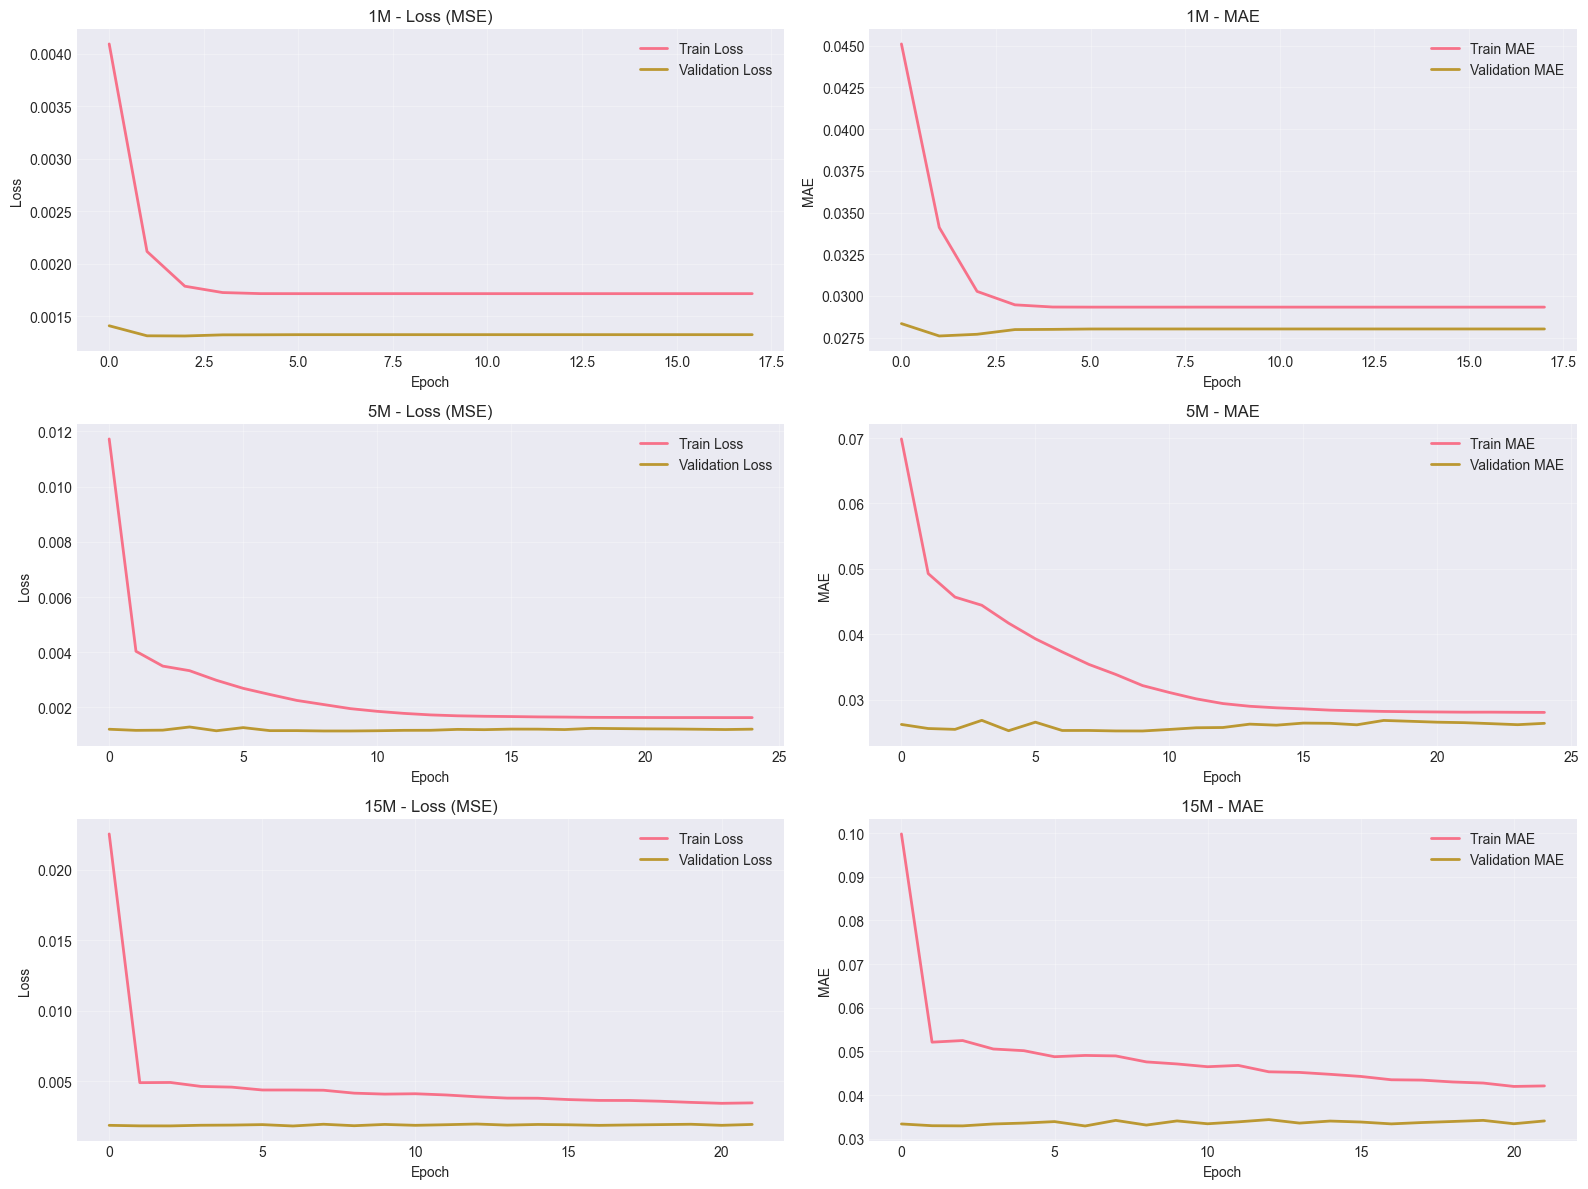

✅ Training history plot saved: lstm_training_history.png


In [33]:
# Plot training history for all timeframes
fig, axes = plt.subplots(len(timeframes), 2, figsize=(16, 12))

for idx, tf in enumerate(timeframes):
    # Loss plot
    ax = axes[idx, 0]
    ax.plot(training_history[tf]['loss'], label='Train Loss', linewidth=2)
    ax.plot(training_history[tf]['val_loss'], label='Validation Loss', linewidth=2)
    ax.set_title(f'{tf.upper()} - Loss (MSE)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # MAE plot
    ax = axes[idx, 1]
    ax.plot(training_history[tf]['mae'], label='Train MAE', linewidth=2)
    ax.plot(training_history[tf]['val_mae'], label='Validation MAE', linewidth=2)
    ax.set_title(f'{tf.upper()} - MAE')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MAE')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Training history plot saved: lstm_training_history.png")

## Generate Predictions with Autoregressive Approach



In [34]:
# Generate predictions using autoregressive approach (like Hybrid Model)
lstm_predictions = {}

for tf in timeframes:
    print(f"\n{'='*60}")
    print(f"Generating autoregressive predictions for {tf.upper()}")
    print(f"{'='*60}")

    scaler = lstm_datasets[tf]['scaler']

    X_train = lstm_datasets[tf]['X_train']
    X_valid = lstm_datasets[tf]['X_valid']

    y_train_pred_scaled = lstm_models[tf].predict(X_train, verbose=0).flatten()
    y_valid_pred_scaled = lstm_models[tf].predict(X_valid, verbose=0).flatten()

    # Inverse transform
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
    y_valid_pred = scaler.inverse_transform(y_valid_pred_scaled.reshape(-1, 1)).flatten()


    test_data_scaled = scaler.transform(lstm_datasets[tf]['test_original'].reshape(-1, 1)).flatten()

    train_data_scaled = scaler.transform(lstm_datasets[tf]['train_original'].reshape(-1, 1)).flatten()
    current_batch = train_data_scaled[-window_size:].reshape(1, window_size, 1)

    y_test_pred_scaled = []
    for i in range(len(test_data_scaled)):
        # Predict next value
        pred = lstm_models[tf].predict(current_batch, verbose=0)[0, 0]
        y_test_pred_scaled.append(pred)

        # Update window: remove first, append predicted
        current_batch = np.append(current_batch[:, 1:, :], [[[pred]]], axis=1)

    y_test_pred_scaled = np.array(y_test_pred_scaled)
    y_test_pred = scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

    # Get actual values (lstm_target = trend + resid)
    y_train_actual = lstm_datasets[tf]['train_original'][window_size:]
    y_valid_actual = lstm_datasets[tf]['valid_original'][window_size:]
    y_test_actual = lstm_datasets[tf]['test_original']

    # Store predictions
    lstm_predictions[tf] = {
        'train': {
            'actual': y_train_actual,
            'predicted': y_train_pred,
            'seasonal': lstm_datasets[tf]['train_seasonal'][window_size:]
        },
        'valid': {
            'actual': y_valid_actual,
            'predicted': y_valid_pred,
            'seasonal': lstm_datasets[tf]['valid_seasonal'][window_size:]
        },
        'test': {
            'actual': y_test_actual,
            'predicted': y_test_pred,
            'seasonal': lstm_datasets[tf]['test_seasonal']
        }
    }

    print(f"✅ Generated predictions:")
    print(f"  Train: {len(y_train_pred)} samples")
    print(f"  Valid: {len(y_valid_pred)} samples")
    print(f"  Test:  {len(y_test_pred)} samples (autoregressive)")


Generating autoregressive predictions for 1M
✅ Generated predictions:
  Train: 60504 samples
  Valid: 15108 samples
  Test:  13620 samples (autoregressive)

Generating autoregressive predictions for 5M
✅ Generated predictions:
  Train: 12081 samples
  Valid: 3003 samples
  Test:  2724 samples (autoregressive)

Generating autoregressive predictions for 15M
✅ Generated predictions:
  Train: 4011 samples
  Valid: 985 samples
  Test:  908 samples (autoregressive)


## Evaluate LSTM Performance on Decomposed Residuals



In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Compute metrics for LSTM residual predictions
lstm_metrics = {}

for tf in timeframes:
    print(f"\n{'='*60}")
    print(f"LSTM Metrics for {tf.upper()}")
    print(f"{'='*60}")

    lstm_metrics[tf] = {}

    for split in ['train', 'valid', 'test']:
        actual = lstm_predictions[tf][split]['actual']
        predicted = lstm_predictions[tf][split]['predicted']

        mse = mean_squared_error(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        rmse = math.sqrt(mse)

        lstm_metrics[tf][split] = {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse
        }

        print(f"\n{split.upper()} Set:")
        print(f"  MSE:  {mse:.6f}")
        print(f"  MAE:  {mae:.6f}")
        print(f"  RMSE: {rmse:.6f}")

# Export metrics summary
metrics_summary = []
for tf in timeframes:
    for split in ['train', 'valid', 'test']:
        metrics_summary.append({
            'timeframe': tf,
            'split': split,
            'MSE': lstm_metrics[tf][split]['MSE'],
            'MAE': lstm_metrics[tf][split]['MAE'],
            'RMSE': lstm_metrics[tf][split]['RMSE']
        })

metrics_df = pd.DataFrame(metrics_summary)
metrics_df.to_csv('lstm_residual_metrics.csv', index=False)
print(f"\n✅ Metrics exported: lstm_residual_metrics.csv")


LSTM Metrics for 1M

TRAIN Set:
  MSE:  193.106285
  MAE:  9.814005
  RMSE: 13.896269

VALID Set:
  MSE:  148.027789
  MAE:  9.296519
  RMSE: 12.166667

TEST Set:
  MSE:  176.014975
  MAE:  10.092374
  RMSE: 13.267064

LSTM Metrics for 5M

TRAIN Set:
  MSE:  2446.969722
  MAE:  34.261985
  RMSE: 49.466855

VALID Set:
  MSE:  1705.745381
  MAE:  30.698931
  RMSE: 41.300670

TEST Set:
  MSE:  1927.883984
  MAE:  32.877702
  RMSE: 43.907676

LSTM Metrics for 15M

TRAIN Set:
  MSE:  15525.310052
  MAE:  86.521883
  RMSE: 124.600602

VALID Set:
  MSE:  8969.129650
  MAE:  72.932349
  RMSE: 94.705489

TEST Set:
  MSE:  12965.336792
  MAE:  81.592850
  RMSE: 113.865433

✅ Metrics exported: lstm_residual_metrics.csv


In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

def calculate_smape(actual, predicted):
    """
    Calculate Symmetric Mean Absolute Percentage Error (sMAPE)
    sMAPE = (100 / n) * Σ(|actual - predicted| / (|actual| + |predicted|) / 2)
    Range: 0% to 200% (lower is better)
    """
    numerator = np.abs(actual - predicted)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    # Avoid division by zero
    denominator = np.where(denominator == 0, 1, denominator)
    return np.mean(numerator / denominator) * 100

# Evaluate hybrid model (Prophet + LSTM)
print(f"\n{'='*80}")
print(f"HYBRID MODEL EVALUATION (Prophet + LSTM Residual Corrections)")
print(f"{'='*80}\n")

hybrid_metrics = {}
prophet_only_metrics = {}

for tf in timeframes:
    print(f"\n{'='*70}")
    print(f"Evaluating {tf.upper()} timeframe")
    print(f"{'='*70}")

    hybrid_metrics[tf] = {}
    prophet_only_metrics[tf] = {}

    for split in ['train', 'valid', 'test']:
        prophet_data = residuals_all[tf][split]

        # Get LSTM predictions
        if split in ['train', 'valid']:
            prophet_actual = prophet_data['actual'].values[window_size:]
            prophet_pred = prophet_data['predicted'].values[window_size:]
            lstm_residual_pred = lstm_predictions[tf][split]['predicted'] + lstm_predictions[tf][split]['seasonal']
        else:
            prophet_actual = prophet_data['actual'].values
            prophet_pred = prophet_data['predicted'].values
            lstm_residual_pred = lstm_predictions[tf][split]['predicted'] + lstm_predictions[tf][split]['seasonal']


        hybrid_pred = prophet_pred + lstm_residual_pred


        mse_hybrid = mean_squared_error(prophet_actual, hybrid_pred)
        mae_hybrid = mean_absolute_error(prophet_actual, hybrid_pred)
        r2_hybrid = r2_score(prophet_actual, hybrid_pred)
        smape_hybrid = calculate_smape(prophet_actual, hybrid_pred)
        rmse_hybrid = math.sqrt(mse_hybrid)

        hybrid_metrics[tf][split] = {
            'MSE': mse_hybrid,
            'MAE': mae_hybrid,
            'RMSE': rmse_hybrid,
            'R2': r2_hybrid,
            'sMAPE': smape_hybrid
        }

        # Metrics for Prophet Only (baseline)
        mse_prophet = mean_squared_error(prophet_actual, prophet_pred)
        mae_prophet = mean_absolute_error(prophet_actual, prophet_pred)
        r2_prophet = r2_score(prophet_actual, prophet_pred)
        smape_prophet = calculate_smape(prophet_actual, prophet_pred)
        rmse_prophet = math.sqrt(mse_prophet)

        prophet_only_metrics[tf][split] = {
            'MSE': mse_prophet,
            'MAE': mae_prophet,
            'RMSE': rmse_prophet,
            'R2': r2_prophet,
            'sMAPE': smape_prophet
        }

        # Print comparison
        print(f"\n{split.upper()} Set ({len(prophet_actual)} samples):")
        print(f"  {'Metric':<12} {'Prophet Only':<18} {'Hybrid (P+L)':<18} {'Improvement':<15}")
        print(f"  {'-'*12} {'-'*18} {'-'*18} {'-'*15}")

        # MSE
        mse_improv = ((mse_prophet - mse_hybrid) / mse_prophet * 100) if mse_prophet > 0 else 0
        print(f"  {'MSE':<12} {mse_prophet:>16.2f}   {mse_hybrid:>16.2f}   {mse_improv:>13.2f}%")

        # MAE
        mae_improv = ((mae_prophet - mae_hybrid) / mae_prophet * 100) if mae_prophet > 0 else 0
        print(f"  {'MAE':<12} {mae_prophet:>16.2f}   {mae_hybrid:>16.2f}   {mae_improv:>13.2f}%")

        # RMSE
        rmse_improv = ((rmse_prophet - rmse_hybrid) / rmse_prophet * 100) if rmse_prophet > 0 else 0
        print(f"  {'RMSE':<12} {rmse_prophet:>16.2f}   {rmse_hybrid:>16.2f}   {rmse_improv:>13.2f}%")

        # R²
        r2_improv = ((r2_hybrid - r2_prophet) / (1 - r2_prophet) * 100) if r2_prophet < 1 else 0
        print(f"  {'R²':<12} {r2_prophet:>16.4f}   {r2_hybrid:>16.4f}   {r2_improv:>13.2f}%")

        # sMAPE
        smape_improv = ((smape_prophet - smape_hybrid) / smape_prophet * 100) if smape_prophet > 0 else 0
        print(f"  {'sMAPE (%)':<12} {smape_prophet:>16.2f}   {smape_hybrid:>16.2f}   {smape_improv:>13.2f}%")

# Export comprehensive metrics
print(f"\n{'='*80}")
print(f"Exporting comprehensive metrics...")
print(f"{'='*80}\n")

metrics_comparison = []
for tf in timeframes:
    for split in ['train', 'valid', 'test']:
        metrics_comparison.append({
            'timeframe': tf,
            'split': split,
            'model': 'Prophet Only',
            'MSE': prophet_only_metrics[tf][split]['MSE'],
            'MAE': prophet_only_metrics[tf][split]['MAE'],
            'RMSE': prophet_only_metrics[tf][split]['RMSE'],
            'R2': prophet_only_metrics[tf][split]['R2'],
            'sMAPE': prophet_only_metrics[tf][split]['sMAPE']
        })
        metrics_comparison.append({
            'timeframe': tf,
            'split': split,
            'model': 'Hybrid (Prophet+LSTM)',
            'MSE': hybrid_metrics[tf][split]['MSE'],
            'MAE': hybrid_metrics[tf][split]['MAE'],
            'RMSE': hybrid_metrics[tf][split]['RMSE'],
            'R2': hybrid_metrics[tf][split]['R2'],
            'sMAPE': hybrid_metrics[tf][split]['sMAPE']
        })

comparison_df = pd.DataFrame(metrics_comparison)
comparison_df.to_csv('hybrid_model_evaluation.csv', index=False)
print(f"✅ Comprehensive metrics exported: hybrid_model_evaluation.csv")

# Summary statistics
print(f"\n{'='*80}")
print(f"SUMMARY - TEST SET PERFORMANCE")
print(f"{'='*80}\n")

for tf in timeframes:
    prophet_r2 = prophet_only_metrics[tf]['test']['R2']
    hybrid_r2 = hybrid_metrics[tf]['test']['R2']
    prophet_mae = prophet_only_metrics[tf]['test']['MAE']
    hybrid_mae = hybrid_metrics[tf]['test']['MAE']
    mae_improvement = ((prophet_mae - hybrid_mae) / prophet_mae * 100)

    print(f"{tf.upper()}:")
    print(f"  Prophet R²: {prophet_r2:.4f} | Hybrid R²: {hybrid_r2:.4f}")
    print(f"  Prophet MAE: {prophet_mae:.2f} | Hybrid MAE: {hybrid_mae:.2f} ({mae_improvement:+.2f}% improvement)")
    print()


HYBRID MODEL EVALUATION (Prophet + LSTM Residual Corrections)


Evaluating 1M timeframe

TRAIN Set (60504 samples):
  Metric       Prophet Only       Hybrid (P+L)       Improvement    
  ------------ ------------------ ------------------ ---------------
  MSE                    197.74             193.11            2.34%
  MAE                      9.85               9.81            0.34%
  RMSE                    14.06              13.90            1.18%
  R²                     0.8117             0.8161            2.34%
  sMAPE (%)               50.85              50.42            0.84%

VALID Set (15108 samples):
  Metric       Prophet Only       Hybrid (P+L)       Improvement    
  ------------ ------------------ ------------------ ---------------
  MSE                    164.17             148.03            9.83%
  MAE                      9.79               9.30            5.01%
  RMSE                    12.81              12.17            5.04%
  R²                     0.6577    

## Save LSTM Predictions with Seasonal Components


In [37]:
# Save LSTM residual predictions with seasonal component for hybrid forecasting
for tf in timeframes:
    # Combine all splits
    train_df = pd.DataFrame({
        'lstm_target_actual': lstm_predictions[tf]['train']['actual'],
        'lstm_target_predicted': lstm_predictions[tf]['train']['predicted'],
        'seasonal': lstm_predictions[tf]['train']['seasonal'],
        'split': 'train'
    })

    valid_df = pd.DataFrame({
        'lstm_target_actual': lstm_predictions[tf]['valid']['actual'],
        'lstm_target_predicted': lstm_predictions[tf]['valid']['predicted'],
        'seasonal': lstm_predictions[tf]['valid']['seasonal'],
        'split': 'valid'
    })

    test_df = pd.DataFrame({
        'lstm_target_actual': lstm_predictions[tf]['test']['actual'],
        'lstm_target_predicted': lstm_predictions[tf]['test']['predicted'],
        'seasonal': lstm_predictions[tf]['test']['seasonal'],
        'split': 'test'
    })

    # Add reconstructed residual (lstm_target + seasonal)
    train_df['residual_predicted'] = train_df['lstm_target_predicted'] + train_df['seasonal']
    valid_df['residual_predicted'] = valid_df['lstm_target_predicted'] + valid_df['seasonal']
    test_df['residual_predicted'] = test_df['lstm_target_predicted'] + test_df['seasonal']

    # Concatenate
    all_preds = pd.concat([train_df, valid_df, test_df], ignore_index=True)

    # Save
    output_path = f'lstm_{tf}_residual_predictions.csv'
    all_preds.to_csv(output_path, index=False)
    print(f"✅ Saved: {output_path}")

    print(f"\n{tf.upper()} - Prediction components:")
    print(f"  lstm_target_predicted: LSTM output (trend + resid)")
    print(f"  seasonal: Seasonal component from decomposition")
    print(f"  residual_predicted: lstm_target + seasonal (full residual)")
    print(f"  Final hybrid = Prophet + residual_predicted")

print(f"\n{'='*60}")
print(f"All LSTM residual predictions saved with seasonal components")
print(f"{'='*60}")

✅ Saved: lstm_1m_residual_predictions.csv

1M - Prediction components:
  lstm_target_predicted: LSTM output (trend + resid)
  seasonal: Seasonal component from decomposition
  residual_predicted: lstm_target + seasonal (full residual)
  Final hybrid = Prophet + residual_predicted
✅ Saved: lstm_5m_residual_predictions.csv

5M - Prediction components:
  lstm_target_predicted: LSTM output (trend + resid)
  seasonal: Seasonal component from decomposition
  residual_predicted: lstm_target + seasonal (full residual)
  Final hybrid = Prophet + residual_predicted
✅ Saved: lstm_15m_residual_predictions.csv

15M - Prediction components:
  lstm_target_predicted: LSTM output (trend + resid)
  seasonal: Seasonal component from decomposition
  residual_predicted: lstm_target + seasonal (full residual)
  Final hybrid = Prophet + residual_predicted

All LSTM residual predictions saved with seasonal components


## Generate Hybrid Predictions (Prophet + LSTM)

In [38]:
# Generate and export hybrid predictions (Prophet + LSTM corrections)
for tf in timeframes:
    print(f"\n{'='*60}")
    print(f"Generating Hybrid Predictions for {tf.upper()}")
    print(f"{'='*60}")
    
    # Load Prophet predictions
    prophet_df = pd.read_csv(f'prophet_{tf}_all_predictions.csv')
    prophet_df['timestamp'] = pd.to_datetime(prophet_df['timestamp'])
    
    # Prepare hybrid predictions
    hybrid_results = []
    
    for split in ['train', 'valid', 'test']:
        prophet_split = prophet_df[prophet_df['split'] == split].copy().reset_index(drop=True)
        
        # Get LSTM residual predictions
        if split in ['train', 'valid']:
            # Skip first window_size samples (no LSTM predictions for them)
            prophet_split = prophet_split.iloc[window_size:].reset_index(drop=True)
            lstm_residual_pred = lstm_predictions[tf][split]['predicted'] + lstm_predictions[tf][split]['seasonal']
        else:
            # Test set: full length
            lstm_residual_pred = lstm_predictions[tf][split]['predicted'] + lstm_predictions[tf][split]['seasonal']
        
        # Hybrid = Prophet + LSTM residual correction
        prophet_split['lstm_residual_correction'] = lstm_residual_pred
        prophet_split['hybrid_predicted'] = prophet_split['predicted'] + lstm_residual_pred
        
        hybrid_results.append(prophet_split)
    
    # Combine all splits
    hybrid_df = pd.concat(hybrid_results, ignore_index=True)
    
    # Export
    output_path = f'hybrid_{tf}_predictions.csv'
    hybrid_df.to_csv(output_path, index=False)
    
    print(f"✅ Exported: {output_path}")
    print(f"   Total samples: {len(hybrid_df)}")
    print(f"   Columns: {list(hybrid_df.columns)}")
    print(f"   Train: {len(hybrid_df[hybrid_df['split']=='train'])}")
    print(f"   Valid: {len(hybrid_df[hybrid_df['split']=='valid'])}")
    print(f"   Test:  {len(hybrid_df[hybrid_df['split']=='test'])}")

print(f"\n{'='*60}")
print(f"All hybrid predictions exported successfully!")
print(f"{'='*60}")


Generating Hybrid Predictions for 1M
✅ Exported: hybrid_1m_predictions.csv
   Total samples: 89232
   Columns: ['timestamp', 'actual', 'predicted', 'yhat_lower', 'yhat_upper', 'error', 'abs_error', 'error_pct', 'split', 'lstm_residual_correction', 'hybrid_predicted']
   Train: 60504
   Valid: 15108
   Test:  13620

Generating Hybrid Predictions for 5M
✅ Exported: hybrid_5m_predictions.csv
   Total samples: 17808
   Columns: ['timestamp', 'actual', 'predicted', 'yhat_lower', 'yhat_upper', 'error', 'abs_error', 'error_pct', 'split', 'lstm_residual_correction', 'hybrid_predicted']
   Train: 12081
   Valid: 3003
   Test:  2724

Generating Hybrid Predictions for 15M
✅ Exported: hybrid_15m_predictions.csv
   Total samples: 5904
   Columns: ['timestamp', 'actual', 'predicted', 'yhat_lower', 'yhat_upper', 'error', 'abs_error', 'error_pct', 'split', 'lstm_residual_correction', 'hybrid_predicted']
   Train: 4011
   Valid: 985
   Test:  908

All hybrid predictions exported successfully!
